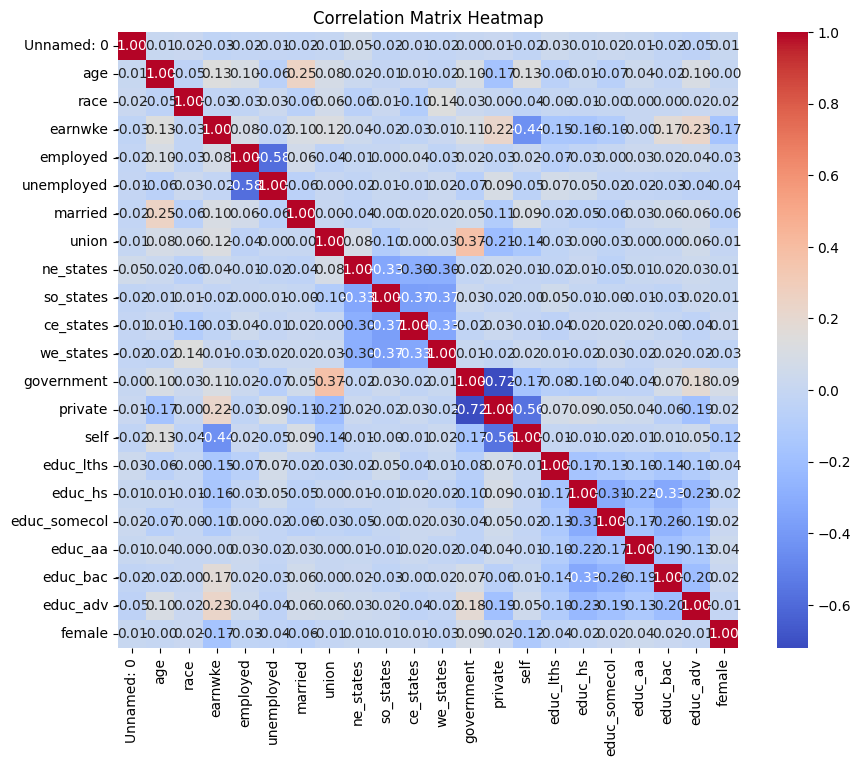

In [1]:
import pandas as pd
import numpy as np

#read data
train_df = pd.read_csv('/kaggle/input/teco-psda-exercisesheet1-employment-2024/employment_train.csv')
test_df = pd.read_csv('/kaggle/input/teco-psda-exercisesheet1-employment-2024/employment_test.csv')

# data preprocessin
# deal earnwke problem
train_df['earnwke'] = train_df['earnwke'].fillna('-1')
train_df['earnwke'] = train_df['earnwke'].str.replace(',', '.').astype(float)
test_df['earnwke'] = test_df['earnwke'].fillna('-1')
test_df['earnwke'] = test_df['earnwke'].str.replace(',', '.').astype(float)

import seaborn as sns
import matplotlib.pyplot as plt

# first take look at correlation matrix
corr_matrix = train_df.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [2]:
from sklearn.model_selection import train_test_split, cross_val_predict


# define goal
X = train_df.drop(['employed', 'unemployed'], axis=1)
y = train_df['employed']
X_test = test_df

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report

# initialize base model
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
gbm_base = GradientBoostingClassifier(random_state=42)
svm_base = SVC(probability=True, class_weight='balanced', random_state=42)

# train base model
rf_base.fit(X_train, y_train)
gbm_base.fit(X_train, y_train)
svm_base.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [4]:
#generize meta
X_train_meta = np.zeros((X_train.shape[0], 3))  # 3 basemodel
X_train_meta[:, 0] = cross_val_predict(rf_base, X_train, y_train, cv=5, method='predict_proba')[:, 1]
X_train_meta[:, 1] = cross_val_predict(gbm_base, X_train, y_train, cv=5, method='predict_proba')[:, 1]
X_train_meta[:, 2] = cross_val_predict(svm_base, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# meta classifier
meta_clf = LogisticRegression(class_weight='balanced')
meta_clf.fit(X_train_meta, y_train)


LogisticRegression(class_weight='balanced')

In [5]:
# try on validation data
X_val_meta = np.zeros((X_val.shape[0], 3))
X_val_meta[:, 0] = rf_base.predict_proba(X_val)[:, 1]
X_val_meta[:, 1] = gbm_base.predict_proba(X_val)[:, 1]
X_val_meta[:, 2] = svm_base.predict_proba(X_val)[:, 1]

y_pred_meta = meta_clf.predict(X_val_meta)

# accurancy
accuracy_meta = accuracy_score(y_val, y_pred_meta)
recall_1_meta = recall_score(y_val, y_pred_meta, pos_label=1)
recall_0_meta = recall_score(y_val, y_pred_meta, pos_label=0)

print(f'Accuracy: {accuracy_meta}')
print(f'Recall for Employed=1: {recall_1_meta}')
print(f'Recall for Employed=0: {recall_0_meta}')

Accuracy: 0.6644295302013423
Recall for Employed=1: 0.6885069817400644
Recall for Employed=0: 0.4642857142857143


In [6]:
# test data meta
X_test_meta = np.zeros((X_test.shape[0], 3))
X_test_meta[:, 0] = rf_base.predict_proba(X_test)[:, 1]
X_test_meta[:, 1] = gbm_base.predict_proba(X_test)[:, 1]
X_test_meta[:, 2] = svm_base.predict_proba(X_test)[:, 1]

# prediction and save
y_test_pred = meta_clf.predict(X_test_meta)

result_df = pd.DataFrame({
    'Id': test_df.iloc[:, 0],
    'Category': y_test_pred
})

result_df.to_csv('result.csv', index=False)